In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.utils as vutils

from torchvision.datasets import CIFAR10

from utils_swg.fid_score import *
from utils_swg.nn_cifar import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
imsize = 64
c = 3

transform=transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()
])


train_dataset = torchvision.datasets.CIFAR10(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

Files already downloaded and verified
Files already downloaded and verified


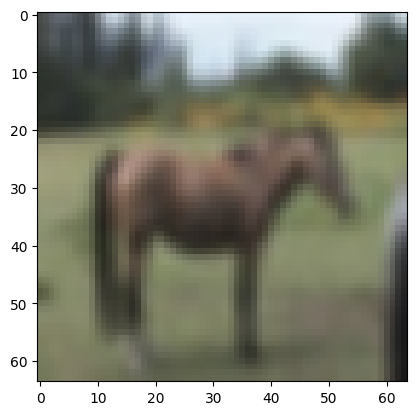

In [4]:
real_cpu = torch.zeros((10000,3,64,64))

cpt = 0
for data, _ in test_loader:
    if cpt+32>10000:
#         real_cpu[cpt:] = inverse_logit(data)
        real_cpu[cpt:] = data[:10000-cpt]
        break
    else:
#         real_cpu[cpt:cpt+32] = inverse_logit(data)
        real_cpu[cpt:cpt+32] = data
    cpt += 32
    
plt.imshow(np.transpose(real_cpu[-1],(1,2,0)))
plt.show()


real_cpu = torch.transpose(real_cpu, 1, 2)
real_cpu = torch.transpose(real_cpu, 2, 3)

In [5]:
def get_model(path_model):
    d_latent = 100

    G = Generator(d_latent).to(device)
    G.load_state_dict(torch.load(path_model))
    G = G.to(device)
    
    return G


def get_FID(G):
    d_latent = 100
    gen_imgs = torch.zeros((10000,3,64,64))

    for k in range(10):
        z = torch.randn((1000, d_latent), device=device)
        imgs = G(z).detach().cpu()
        gen_imgs[k*1000: (k+1)*1000] = imgs


    gen_imgs = torch.transpose(gen_imgs, 1, 2)
    gen_imgs = torch.transpose(gen_imgs, 2, 3)

    fid = evaluate_fid_score(real_cpu.detach().cpu().numpy(), gen_imgs.detach().cpu().numpy(), batch_size=25)
        
    return fid


def plot_grid(G):
    d_latent = 100
    z = torch.randn((64, d_latent), device=device)
    gen_imgs = G(z).detach().cpu()
    
    gen_imgs = torch.transpose(gen_imgs, 1, 2)
    gen_imgs = torch.transpose(gen_imgs, 2, 3)
        
    grid = vutils.make_grid(torch.tensor(np.transpose(gen_imgs[:64], (0,3,1,2)), dtype=torch.float), padding=2, normalize=True)
    grid_np = np.transpose(grid, (1,2,0))

    plt.imshow(grid_np)
    plt.axis("off")
    plt.show()

### SWG

/tmp/ipykernel_186626/518143158.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = vutils.make_grid(torch.tensor(np.transpose(gen_imgs[:64], (0,3,1,2)), dtype=torch.float), padding=2, normalize=True)


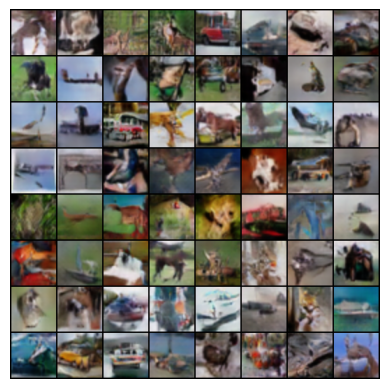

37.54418401889791

In [15]:
## 500 epochs, batch size 64
path_model = "./results/swg_cifar_sw.model"

model = get_model(path_model)
fid = get_FID(model)
plot_grid(model)

fid